In [1]:
!pip install easyocr -q
!pip install kaggle -q 
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0
!pip install tensorflow-addons -q 
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.2/619.2 KB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 117.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 15.2 MB/s eta 0:00:0

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!mkdir ~/.kaggle
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d williamscott701/memotion-dataset-7k

 99% 692M/695M [00:21<00:00, 37.8MB/s]
100% 695M/695M [00:21<00:00, 34.5MB/s]


In [5]:
!unzip -qq /content/memotion-dataset-7k.zip

In [15]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv1D, Embedding
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow_hub as hub
import tensorflow_text as text

import tensorflow_addons as tfa

import easyocr

import cv2

from PIL import Image
from PIL import ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [75]:
df = pd.read_csv('/content/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
# df = df.drop(columns = ['text_ocr', 'text_corrected'])
df.head()

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [76]:
df = df.replace({'humour': {'not_funny': 0, 'funny': 1, 'very_funny': 2, 'hilarious':3},
            'sarcasm': {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 2, 'very_twisted': 3},
            'offensive': {'not_offensive': 0, 'slight': 1, 'very_offensive': 2, 'hateful_offensive': 3},
            'motivational': {'not_motivational': 0, 'motivational': 1},
            'overall_sentiment': {'very_negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very_positive': 4}})

In [77]:
cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

image_name           False
text_ocr             False
text_corrected       False
humour               False
sarcasm              False
offensive            False
motivational         False
overall_sentiment    False
dtype: bool

In [78]:
crupted_images = []
for idx, row in tqdm(cleaned.iterrows()):
  try:
    path = '/content/memotion_dataset_7k/images/'+ row['image_name']
    img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img=cv2.resize(img, (250, 250))
    # crupted_images.append(True)
  except:
    crupted_images.append(row['image_name'])

6830it [00:33, 204.14it/s]


In [71]:
crupted_images

['image_1567.jpg', 'image_4924.jpg', 'image_6357.jpg']

In [82]:
cleaned = cleaned[~(cleaned['image_name'].isin(crupted_images))]

In [83]:
reader = easyocr.Reader(['en'])
batch_size = 25
w = 250
h = 250
OCR_texts = []
temp = []
for idx, name in tqdm(enumerate(cleaned['image_name'].to_list())):
    if idx in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        if len(temp)==batch_size:
            bounds = reader.readtext_batched(temp, n_width=w, n_height=h, )
            OCR_texts+=bounds
            temp = []
        
        path = '/content/memotion_dataset_7k/images/'+name
        temp.append(path)


6353it [07:18, 14.40it/s]/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
6827it [07:49, 14.54it/s]


In [85]:
bounds = reader.readtext_batched(temp, n_width=w, n_height=h,)
OCR_texts+=bounds

In [86]:
len(OCR_texts)

6822

In [33]:
type(X[0])

numpy.ndarray

2 (500, 735)


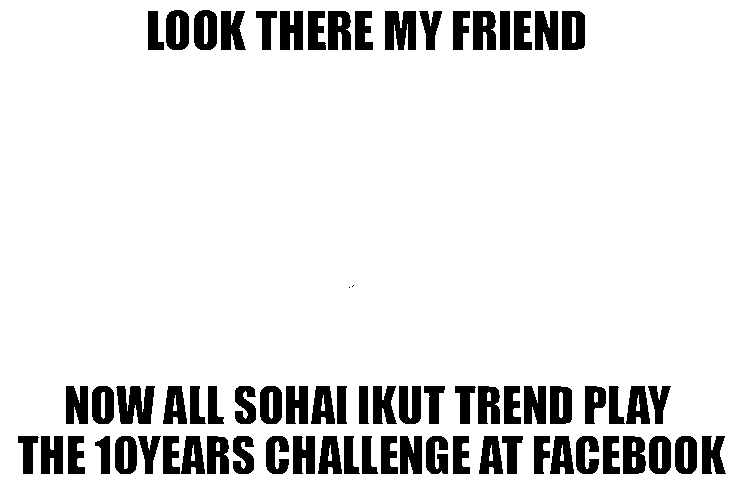

2


In [86]:
im = np.array(Image.open('/content/memotion_dataset_7k/images/image_1.jpg').convert("RGB"))
def preprocess_finale(im):
    im= cv2.bilateralFilter(im,5, 55,60)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _, im = cv2.threshold(im, 240, 255, 1)
    return im
im = preprocess_finale(im)
def display_PIL(nparray):
    image = Image.fromarray(nparray,'L')
    print(np.array(image).ndim, np.array(image).shape)
    display(image)
display_PIL(im)
print(im.ndim)

In [103]:
a = np.broadcast_to(np.expand_dims(im, 2), im.shape+(3, ))
# a.shape
b = Image.fromarray(a)
# type(b.ndim)

In [104]:
import cv2
# url = "https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg"
image = Image.open('/content/memotion_dataset_7k/images/image_1.jpg').convert("RGB")
a = np.broadcast_to(np.expand_dims(im, 2), im.shape+(3, )).shape
print(np.array(image).ndim, np.array(image).shape)
pixel_values = processor(b, return_tensors="pt").pixel_values
print(pixel_values.size())
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text

3 (500, 735, 3)
torch.Size([1, 3, 384, 384])


/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['***']

In [10]:
Y = cleaned.iloc[:,2:]
X = cleaned.iloc[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [11]:
def standardization(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

cleaned['text_corrected'] = standardization(cleaned.text_corrected)

In [12]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [15]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [13]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
#####################################
vocab_size = 100000
sequence_length = 100
#####################################
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = np.asarray(cleaned['text_corrected'])
vectorize_layer.adapt(tf.convert_to_tensor(text_ds))

In [18]:
#####################################
# embedding_dim=50
#####################################

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
text_layers = outputs['pooled_output']

# text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
# text_layers = vectorize_layer(text_input)
# text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(text_layers)
# text_layers = tf.keras.layers.Dropout(0.5)(text_layers)

# text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='relu', return_sequences=True))(net)
# text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='relu', return_sequences=True))(text_layers)

# text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
# text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
# text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)

text_layers = tf.keras.layers.Dense(512, activation="relu")(text_layers)
text_layers = tf.keras.layers.Dropout(0.5)(text_layers)
overall_layer = tf.keras.layers.Dense(2048, activation='softmax')(text_layers)
prediction_layer_1 = tf.keras.layers.Dense(4, activation='softmax', name = 'sarcasm')
prediction_layer_2 = tf.keras.layers.Dense(4, activation='softmax', name = 'humuor')
prediction_layer_3 = tf.keras.layers.Dense(4, activation='softmax', name = 'offensive')
prediction_layer_4 = tf.keras.layers.Dense(1, activation='sigmoid', name = 'motivational')
prediction_layer_5 = tf.keras.layers.Dense(5, activation='softmax', name = 'overall')
output_1 = prediction_layer_1(overall_layer)
output_2 = prediction_layer_2(overall_layer)
output_3 = prediction_layer_3(overall_layer)
output_4 = prediction_layer_4(overall_layer)
output_5 = prediction_layer_5(overall_layer)
model = tf.keras.Model(inputs = [text_input] , outputs = [output_1, output_2, output_3, output_4, output_5])

In [19]:
base_learning_rate = 0.01
losses = {
      "humuor": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
      "sarcasm": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
      "offensive": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
      "motivational": tf.keras.losses.BinaryCrossentropy(from_logits=False),
      "overall": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}
lossWeights = {
      "humuor": 1.0, 
      "sarcasm": 1.0, 
      "offensive": 1.0, 
      "motivational": 1.0,
      "overall": 1.0
}
metric = {
    "humuor": ['acc',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.9)],
    "sarcasm": ['acc',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.9)],
    "offensive": ['acc',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.9)],
    "motivational": ['acc',tfa.metrics.F1Score(num_classes=1, average="micro", threshold = 0.9)],
    "overall": ['acc',tfa.metrics.F1Score(num_classes=5, average="micro", threshold = 0.9)]
}
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss = losses,
              loss_weights= lossWeights,
              metrics=metric)

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
learning_rates = [0.1]#, 0.01, 0.001, 0.0001, 0.00001]
for i in learning_rates:
    model.compile(optimizer=tf.keras.optimizers.RMSprop(i),
              loss = losses,
              loss_weights= lossWeights,
              metrics=['accuracy'])
    
    history = model.fit(x = {"text": X_train},
                    y = {"sarcasm": y_train.sarcasm, 
                         "humuor": y_train.humour, 
                         "offensive": y_train.offensive, 
                         "motivational": y_train.motivational, 
                         "overall": y_train.overall_sentiment},
                    batch_size=32,
                    epochs=2,
                    verbose=2
                   )

Epoch 1/2


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


175/175 - 47s - loss: 5.6393 - sarcasm_loss: 1.1937 - humuor_loss: 1.3064 - offensive_loss: 1.1900 - motivational_loss: 0.6565 - overall_loss: 1.2927 - sarcasm_accuracy: 0.4945 - humuor_accuracy: 0.3423 - offensive_accuracy: 0.3802 - motivational_accuracy: 0.6416 - overall_accuracy: 0.4353 - 47s/epoch - 267ms/step
Epoch 2/2
175/175 - 35s - loss: 5.6379 - sarcasm_loss: 1.1938 - humuor_loss: 1.3044 - offensive_loss: 1.1875 - motivational_loss: 0.6579 - overall_loss: 1.2943 - sarcasm_accuracy: 0.5003 - humuor_accuracy: 0.3412 - offensive_accuracy: 0.3838 - motivational_accuracy: 0.6418 - overall_accuracy: 0.4339 - 35s/epoch - 202ms/step


In [21]:
pd.DataFrame(history.history)

,loss,sarcasm_loss,humuor_loss,offensive_loss,motivational_loss,overall_loss,sarcasm_accuracy,humuor_accuracy,offensive_accuracy,motivational_accuracy,overall_accuracy
0,5.639346,1.193701,1.306410,1.190031,0.656481,1.292723,0.494543,0.342279,0.380211,0.641617,0.435319
1,5.637896,1.193802,1.304406,1.187500,0.657920,1.294269,0.500268,0.341206,0.383790,0.641796,0.433888


In [22]:
evaluate = model.evaluate(x = {"text": X_test},
                    y = {"sarcasm": y_test.sarcasm, 
                         "humuor": y_test.humour, 
                         "offensive": y_test.offensive, 
                         "motivational": y_test.motivational, 
                         "overall": y_test.overall_sentiment},
                    batch_size=32,
                    verbose=2
                   )

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


44/44 - 5s - loss: 5.6072 - sarcasm_loss: 1.1761 - humuor_loss: 1.3194 - offensive_loss: 1.1778 - motivational_loss: 0.6360 - overall_loss: 1.2979 - sarcasm_accuracy: 0.5064 - humuor_accuracy: 0.3383 - offensive_accuracy: 0.4063 - motivational_accuracy: 0.6688 - overall_accuracy: 0.4449 - 5s/epoch - 118ms/step


[5.693905830383301, 1.2083460092544556, 1.3442360162734985, 1.2152080535888672, 0.6417999863624573, 1.284316062927246, 0.5064377784729004, 0.33834049105644226, 0.3605150282382965, 0.6688125729560852, 0.4449213147163391]
